In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cftime
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm


# standard funcs for reading in data
from HiLLA_utils import get_ds, set_time_to_center_of_bounds

# standard variable names, settings for plotting, region bounds etc. 
from config import models, regions, HiLLA_altitudes, path_archive, ens_mems_arise_UK, ens_mems_CE, colours, model_colors, dark_model_colors  

In [2]:
def process(ds):
    ds = ds.sel(time=slice('2050', '2069')).groupby('time.month').mean(dim='time')
    ds = ds.mean(dim='longitude')
    return ds

In [3]:
ds_list = []
for mode_var in tqdm(['h2s04_mmr_nuc', 'h2so4_mmr_acc', 'h2so4_mmr_ait', 'h2so4_mmr_cou']):
    ds = process(get_ds(run = 'u-dm204dn587', var=mode_var, table='AERmon'))
    ds_list.append(ds)
ds_HiLLA_13_UK = xr.merge(ds_list)
ds_HiLLA_13_UK['h2so4_mmr'] = ds_HiLLA_13_UK['h2s04_mmr_nuc'] + ds_HiLLA_13_UK['h2so4_mmr_acc'] + ds_HiLLA_13_UK['h2so4_mmr_ait'] + ds_HiLLA_13_UK['h2so4_mmr_cou']

100%|██████████| 4/4 [01:19<00:00, 19.89s/it]


In [4]:
## repeat for the 15km inj case
ds_list = []
for mode_var in tqdm(['h2s04_mmr_nuc', 'h2so4_mmr_acc', 'h2so4_mmr_ait', 'h2so4_mmr_cou']):
    ds = process(get_ds(run = 'u-dn760', var=mode_var, table='AERmon'))
    ds_list.append(ds)
ds_HiLLA_15_UK = xr.merge(ds_list)
ds_HiLLA_15_UK['h2so4_mmr'] = ds_HiLLA_15_UK['h2s04_mmr_nuc'] + ds_HiLLA_15_UK['h2so4_mmr_acc'] + ds_HiLLA_15_UK['h2so4_mmr_ait'] + ds_HiLLA_15_UK['h2so4_mmr_cou']

100%|██████████| 4/4 [01:17<00:00, 19.27s/it]


In [5]:
### also get CESM: 

# read in a reference var, to get time_bnds, as they are missing on the zonal mean O3 data, which was postprcessed seperately
ref_var_CE = xr.open_dataset(path_archive+'CESM_data/Temperature/case01_60NS_13km_MAMJ_6Tg_TREFHT.nc')

def process_CE(ds):
    ds['time_bnds'] = ref_var_CE['time_bnds'] # add in the missing t_bnds
    ds = set_time_to_center_of_bounds(ds, 'time_bnds') # center the tvalues
    ds = ds.sel(time=slice('2050', '2069')).groupby('time.month').mean(dim='time')
    ds['h2so4_mmr'] = ds['so4_a1a2a3c1c2c3']*(1/0.9796)
    #ds = ds.mean('lon')
    #ds = ds.rename({'lat':'latitude'})
    return ds

ds_HiLLA_13_CE = process_CE(xr.open_dataset(path_archive+'CESM_data/SO4_burdenZ/case01_b.e21.BWSSP245cmip6.f09_g17.polar_SAI_sensitivity_60NS_13km_MAMJ_6Tg.001.cam.h0.so4_a1a2a3c1c2c3_zm_Z3.203501-206912.nc'))
ds_HiLLA_15_CE = process_CE(xr.open_dataset(path_archive+'CESM_data/SO4_burdenZ/case04_b.e21.BWSSP245cmip6.f09_g17.polar_SAI_sensitivity_60NS_15km_MAMJ_6Tg.001.cam.h0.so4_a1a2a3c1c2c3_zm_Z3.203501-206912.nc'))

In [6]:
### and E3SM

def process_E3(ds):
    ds = set_time_to_center_of_bounds(ds, 'time_bnds')
    ds = ds.sel(time=slice('2050', '2069')).groupby('time.month').mean(dim='time')
    ds = ds.mean(dim='lon').rename({'lat':'latitude'})
    return ds
    
ds_HiLLA_13_E3_200 = process_E3(xr.open_dataset(path_archive+'E3SM_data/regridded/Mass_so4/Mass_so4_200.polar.mip.e3sm.01.nc'))
ds_HiLLA_15_E3_200 = process_E3(xr.open_dataset(path_archive+'E3SM_data/regridded/Mass_so4/Mass_so4_200.polar.mip.e3sm.04.nc'))
ds_ssp245_E3_200 = process_E3(xr.open_dataset(path_archive+'E3SM_data/regridded/Mass_so4/Mass_so4_200.polar.mip.e3sm.control.nc'))
    
ds_HiLLA_13_E3_330 = process_E3(xr.open_dataset(path_archive+'E3SM_data/regridded/Mass_so4/Mass_so4_330.polar.mip.e3sm.01.nc'))
ds_HiLLA_15_E3_330 = process_E3(xr.open_dataset(path_archive+'E3SM_data/regridded/Mass_so4/Mass_so4_330.polar.mip.e3sm.04.nc'))
ds_ssp245_E3_330 = process_E3(xr.open_dataset(path_archive+'E3SM_data/regridded/Mass_so4/Mass_so4_330.polar.mip.e3sm.control.nc'))


In [7]:
# use Z3 to check height of the 200 level:
Z3_HiLLA_13_E3 = xr.open_dataset(path_archive+'E3SM_data/Z3/Z3.polar.mip.e3sm.control.nc').mean('time')

ds = Z3_HiLLA_13_E3.where(Z3_HiLLA_13_E3.lat<61, drop=True)
ds = ds.where(ds.lat>59, drop=True)
z = ds.mean('ncol').Z3

print(z.sel(lev=200, method='nearest'))

# also check the height of the 330 level
z.sel(lev=330, method='nearest')

<xarray.DataArray 'Z3' ()> Size: 4B
array(11627.507, dtype=float32)
Coordinates:
    lev      float64 8B 201.0


<xarray.DataArray 'Z3' ()> Size: 4B
array(8451.238, dtype=float32)
Coordinates:
    lev      float64 8B 327.9

Given we only have two levels for E3SM, I just take 200mb as the closest, rather than trying to interpolate to 11km. 

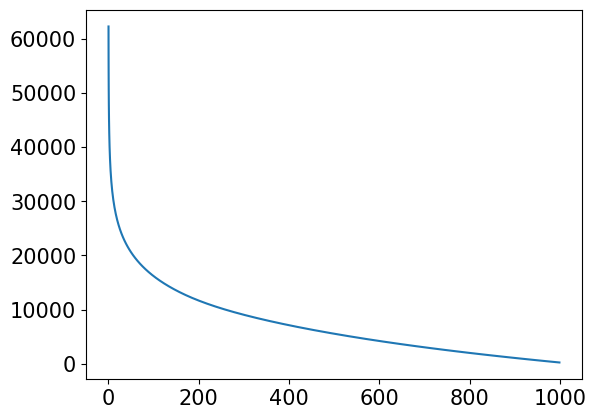

In [8]:
plt.plot(z.lev, z)

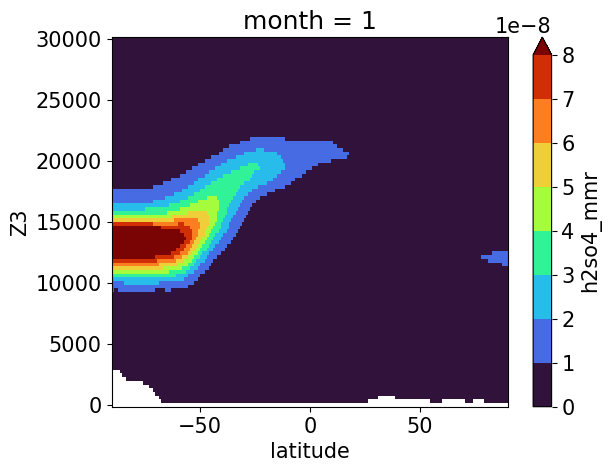

In [9]:
ds_HiLLA_15_CE.isel(month=0).h2so4_mmr.plot(x='latitude', y='Z3', cmap='turbo',
                       levels = np.arange(0, 9E-8, 1E-8))

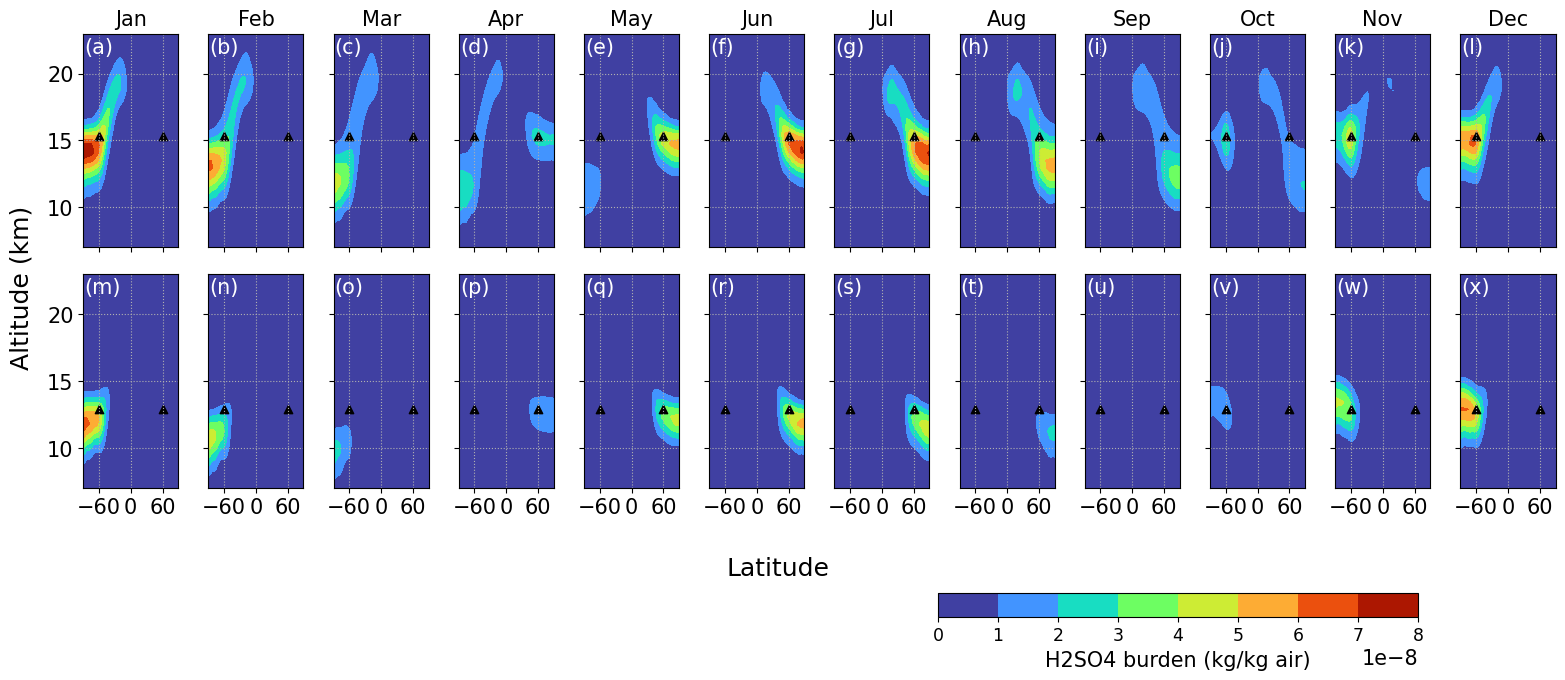

In [10]:
fig, axs = plt.subplots(2, 12, figsize=(16, 6),
                        sharex='all', sharey='all')

heights = [15.36, 12.90]
ds_s = [ds_HiLLA_15_UK, ds_HiLLA_13_UK]
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', '(n)', '(o)', '(p)', '(q)', '(r)', '(s)', '(t)', '(u)', '(v)', '(w)', '(x)']

j=0
i=0
for ds in ds_s:
    for m in ds.month.values:
        
        ax = axs[j, m-1]
        p = ds.sel(month=m)
        #p = p.where(p.altitude<21000, drop=True)
        
        cs=ax.contourf(p.latitude, 0.001*p.altitude,
                       p.h2so4_mmr, cmap='turbo',
                       levels = np.arange(0, 9E-8, 1E-8))
                       #extend='max')
        
        
        ax.grid(ls='dotted')
        ax.set_xticks([-60, 0, 60])
        ax.set_ylim(7, 23)
        ax.text(0.01, 0.91, labels[i], transform=ax.transAxes, color='white')
        ax.scatter([60, -60],
                   [heights[j], heights[j]],
                   marker='^', color='black'
                   )
        
        if j == 0:
            ax.set_title(month_names[m], fontsize='medium')
        i=i+1
        
    j=j+1
    
fig.supxlabel('Latitude')
fig.supylabel('Altitude (km)')

plt.tight_layout()

cbar_ax1 = fig.add_axes([0.6, -0.05, 0.3, 0.04])
cbar1 = fig.colorbar(cs, cax=cbar_ax1, orientation='horizontal', label='H2SO4 burden (kg/kg air)')
cbar1.ax.tick_params(labelsize='small')
#plt.savefig('Figures/H2SO4_burden_UKESM_bymonth.jpg', dpi=450, bbox_inches='tight')
plt.show()

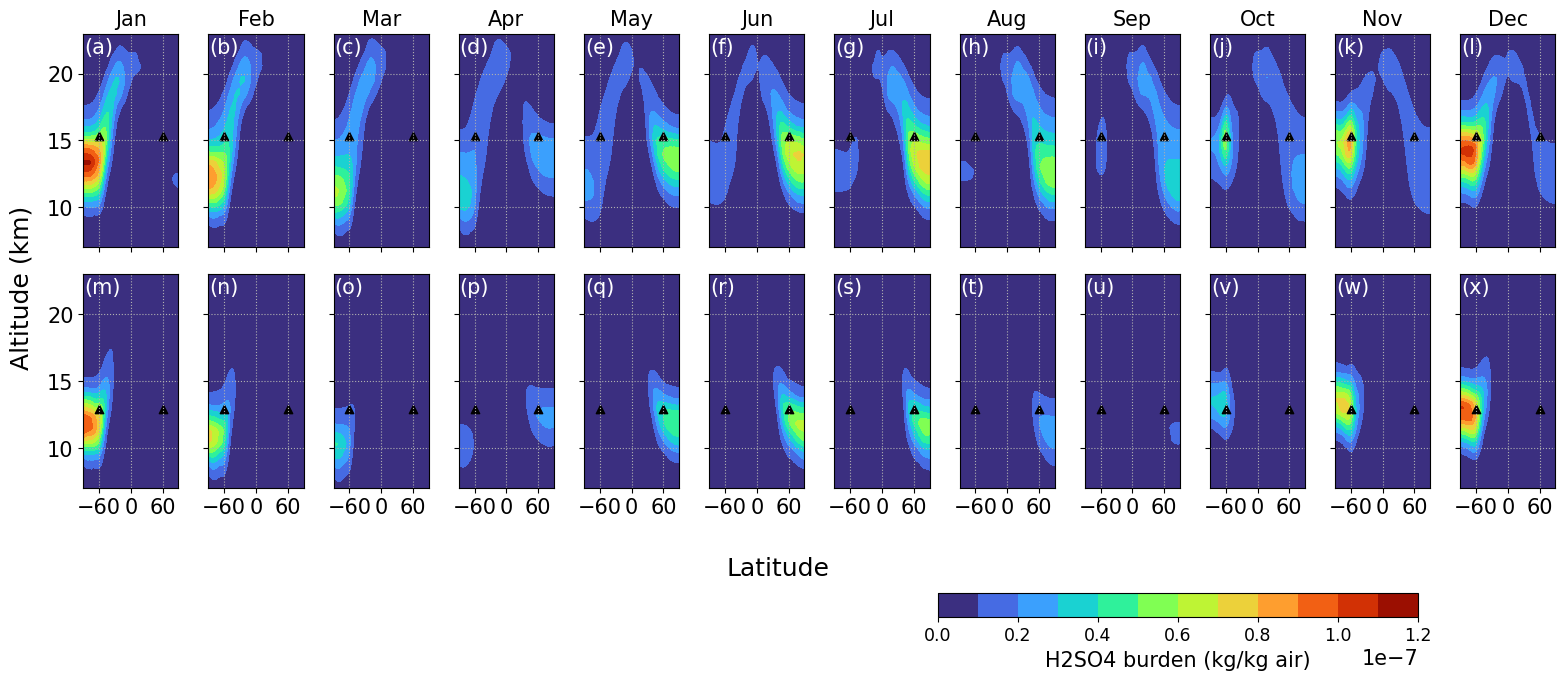

In [11]:
fig, axs = plt.subplots(2, 12, figsize=(16, 6),
                        sharex='all', sharey='all')

heights = [15.36, 12.90]
ds_s = [ds_HiLLA_15_CE, ds_HiLLA_13_CE]
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', '(n)', '(o)', '(p)', '(q)', '(r)', '(s)', '(t)', '(u)', '(v)', '(w)', '(x)']

j=0
i=0
for ds in ds_s:
    for m in ds.month.values:
        
        ax = axs[j, m-1]
        p = ds.sel(month=m)
        #p = p.where(p.Z3<21000, drop=True)
        
        cs=ax.contourf(p.latitude, 0.001*p.Z3,
                       p.h2so4_mmr.transpose(), cmap='turbo',
                       levels = np.arange(0, 1.3E-7, 1E-8))
                       #extend='max')
        
        
        ax.grid(ls='dotted')
        ax.set_xticks([-60, 0, 60])
        ax.set_ylim(7, 23)
        ax.text(0.01, 0.91, labels[i], transform=ax.transAxes, color='white')
        ax.scatter([60, -60],
                   [heights[j], heights[j]],
                   marker='^', color='black'
                   )
        
        if j == 0:
            ax.set_title(month_names[m], fontsize='medium')
        i=i+1
        
    j=j+1
    
fig.supxlabel('Latitude')
fig.supylabel('Altitude (km)')

plt.tight_layout()

cbar_ax1 = fig.add_axes([0.6, -0.05, 0.3, 0.04])
cbar1 = fig.colorbar(cs, cax=cbar_ax1, orientation='horizontal', label='H2SO4 burden (kg/kg air)')
cbar1.ax.tick_params(labelsize='small')
plt.savefig('Figures/H2SO4_burden_CESM_bymonth.jpg', dpi=450, bbox_inches='tight')
plt.show()

In [12]:
### report the hemispheric 11km max: 

## UKESM
print('UKESM')
ds_s = [ds_HiLLA_15_UK, ds_HiLLA_13_UK]
alts = ['15km inj', '13km inj']

i=0
for ds in ds_s:
    print(alts[i])
    test = ds.sel(latitude=slice(0, 91)) # NH only
    test = test.where(test.model_level_number==40, drop=True) # 10.93  11.48 km
    print('max value: ', test.h2so4_mmr.max().values)
    
    args = test.h2so4_mmr.argmax(dim=['month', 'latitude'])
    print('month: ', test.h2so4_mmr.month.values[args['month'].item()])
    print('latitude: ', test.h2so4_mmr.latitude.values[args['latitude'].item()])
    i=i+1


## CESM
print('')
print('CESM')
ds_s = [ds_HiLLA_15_CE, ds_HiLLA_13_CE]
alts = ['15km inj', '13km inj']

i=0
for ds in ds_s:
    print(alts[i])
    test = ds.sel(latitude=slice(0, 91)) # NH only
    test = test.sel(Z3=11000, method='nearest') # 10.9
    print('max value: ', test.h2so4_mmr.max().values)
    
    args = test.h2so4_mmr.argmax(dim=['month', 'latitude'])
    print('month: ', test.h2so4_mmr.month.values[args['month'].item()])
    print('latitude: ', test.h2so4_mmr.latitude.values[args['latitude'].item()])
    i=i+1


## E3SM 
print('')
print('E3SM')
ds_s = [ds_HiLLA_15_E3_200, ds_HiLLA_13_E3_200]
alts = ['15km inj', '13km inj']
i=0
for ds in ds_s:
    print(alts[i])
    test = ds.sel(latitude=slice(0, 91)) # NH only
    #test = test.sel(Z3=11000, method='nearest') # 10.9
    print('max value: ', test.Mass_so4_200.max().values)
    
    args = test.Mass_so4_200.argmax(dim=['month', 'latitude'])
    print('month: ', test.Mass_so4_200.month.values[args['month'].item()])
    print('latitude: ', test.Mass_so4_200.latitude.values[args['latitude'].item()])
    i=i+1


UKESM
15km inj
max value:  2.8121086e-08
month:  9
latitude:  89.375
13km inj
max value:  4.6284235e-08
month:  7
latitude:  89.375

CESM
15km inj
max value:  4.0713205614103206e-08
month:  7
latitude:  90.0
13km inj
max value:  5.565949929728533e-08
month:  6
latitude:  90.0

E3SM
15km inj
max value:  5.3838356e-08
month:  7
latitude:  89.5
13km inj
max value:  5.913307e-08
month:  6
latitude:  81.5


In [34]:
### report the 60N 11km max: 

## UKESM
print('UKESM')
ds_s = [ds_HiLLA_15_UK, ds_HiLLA_13_UK]
alts = ['15km inj', '13km inj']

i=0
for ds in ds_s:
    print(alts[i])
    test = ds.sel(latitude=60, method='nearest') #60.6N
    test = test.where(test.model_level_number==40, drop=True) # 10.93  11.48 km
    print('max value: ', test.h2so4_mmr.max().values)
    
    arg = test.h2so4_mmr.argmax(dim='month')
    print('month: ', test.h2so4_mmr.month.values[arg.item()])
    i=i+1


## CESM
print('')
print('CESM')
ds_s = [ds_HiLLA_15_CE, ds_HiLLA_13_CE]
alts = ['15km inj', '13km inj']

i=0
for ds in ds_s:
    print(alts[i])
    test = ds.sel(latitude=60, method='nearest') #60.6N
    test = test.sel(Z3=11000, method='nearest') # 10.9
    print('max value: ', test.h2so4_mmr.max().values)
    
    arg = test.h2so4_mmr.argmax(dim='month')
    print('month: ', test.h2so4_mmr.month.values[arg.item()])
    i=i+1


## E3SM
print('')
print('E3SM')
ds_s = [ds_HiLLA_15_E3_200, ds_HiLLA_13_E3_200]
alts = ['15km inj', '13km inj']

i=0
for ds in ds_s:
    print(alts[i])
    test = ds.sel(latitude=60, method='nearest') #60.6N
    #test = test.sel(Z3=11000, method='nearest') # 10.9
    print('max value: ', test.Mass_so4_200.max().values)
    arg = test.Mass_so4_200.argmax(dim='month')
    print('month: ', test.Mass_so4_200.month.values[arg.item()])
    i=i+1

UKESM
15km inj
max value:  1.5527226e-08
month:  9
13km inj
max value:  2.4922638e-08
month:  6

CESM
15km inj
max value:  2.104294313044765e-08
month:  8
13km inj
max value:  3.070758035487367e-08
month:  6

E3SM
15km inj
max value:  3.4214604e-08
month:  8
13km inj
max value:  4.9611035e-08
month:  6


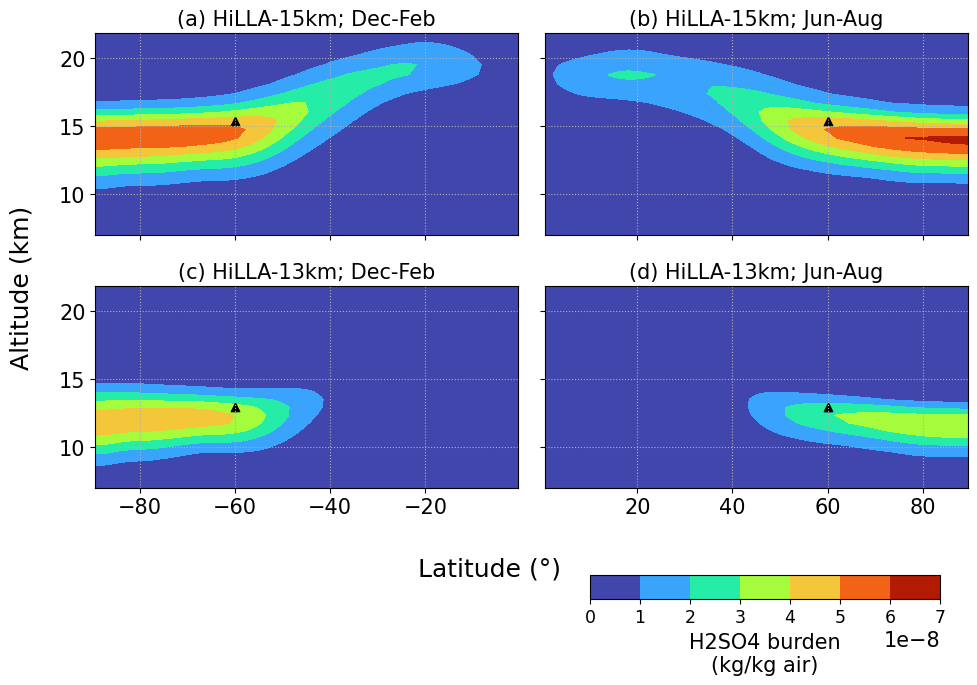

In [14]:
# repeat the plot above, now just summer and winter:

fig, axs = plt.subplots(2, 2, figsize=(10, 6),
                        sharex='col', sharey='all')

heights = [15.36, 12.90]
ds_s = [ds_HiLLA_15_UK, ds_HiLLA_13_UK]

months = [[12, 1, 2], [6, 7, 8]]
xlims = [[-90, 0], [0, 90]]
titles = ['(a) HiLLA-15km; Dec-Feb', '(b) HiLLA-15km; Jun-Aug',
          '(c) HiLLA-13km; Dec-Feb', '(d) HiLLA-13km; Jun-Aug']

t=0
j=0
for ds in ds_s:
    i=0
    for ms in months:
        
        ax = axs[j, i]
        
        p = ds.where(ds.month.isin(ms), drop=True).mean('month')
        p = p.where(p.altitude<22000, drop=True)
        p = p.sel(latitude=slice(xlims[i][0], xlims[i][1]))
        cs=ax.contourf(p.latitude, 0.001*p.altitude,
                       p.h2so4_mmr, cmap='turbo',
                       levels = np.arange(0, 8E-8, 1E-8))
                       #extend='max')
        
        
        ax.grid(ls='dotted')
        #
        ax.set_ylim(7, None)

        if i == 0:
            ax.scatter([-60], [heights[j]], marker='^', color='black')
            
            #ax.set_xlim(-90,0)
        else:
            ax.scatter([60], [heights[j]], marker='^', color='black')
            #ax.set_xlim(0, 50)
        ax.set_title(titles[t], fontsize='medium')
        i=i+1
        t=t+1
        
    j=j+1
    
fig.supxlabel('Latitude (°)')
fig.supylabel('Altitude (km)')

plt.tight_layout()


cbar_ax1 = fig.add_axes([0.6, -0.02, 0.35, 0.04])
cbar1 = fig.colorbar(cs, cax=cbar_ax1, orientation='horizontal', label='H2SO4 burden\n(kg/kg air)')
cbar1.ax.tick_params(labelsize='small')
plt.savefig('Figures/H2SO4_burden_UKESM_byseason.jpg', dpi=450, bbox_inches='tight')

plt.show()

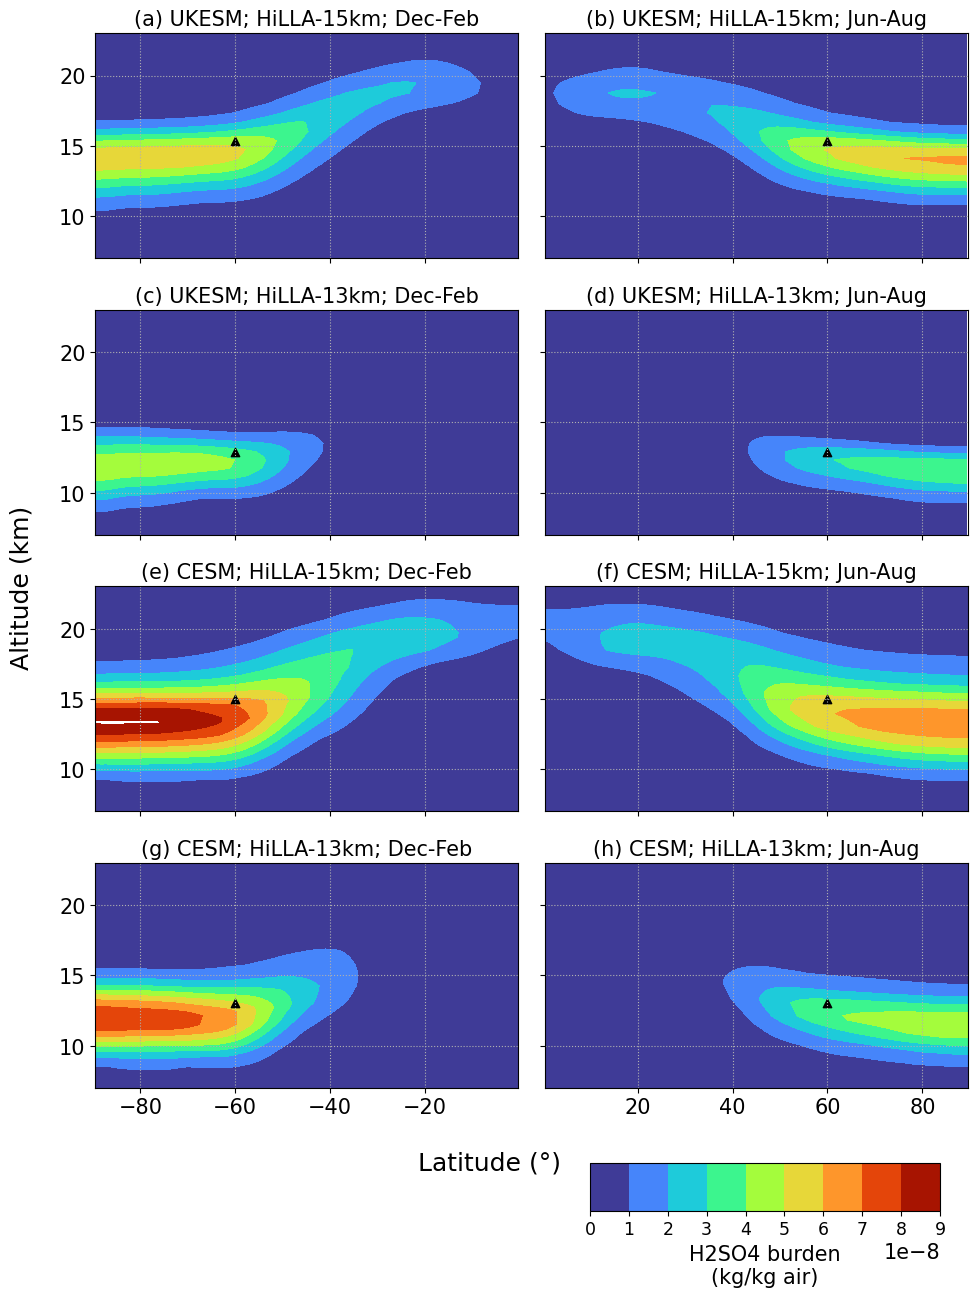

In [15]:
# repeat the plot above, now just summer and winter:

fig, axs = plt.subplots(4, 2, figsize=(10, 12),
                        sharex='col', sharey='all')

heights = [15.36, 12.90, 15, 13] # NB: CESM values are nominal for now, to fix!
ds_s = [ds_HiLLA_15_UK, ds_HiLLA_13_UK, 
        ds_HiLLA_15_CE, ds_HiLLA_13_CE]

months = [[12, 1, 2], [6, 7, 8]]
xlims = [[-90, 0], [0, 90]]
titles = ['(a) UKESM; HiLLA-15km; Dec-Feb', '(b) UKESM; HiLLA-15km; Jun-Aug',
          '(c) UKESM; HiLLA-13km; Dec-Feb', '(d) UKESM; HiLLA-13km; Jun-Aug',
          '(e) CESM; HiLLA-15km; Dec-Feb', '(f) CESM; HiLLA-15km; Jun-Aug',
          '(g) CESM; HiLLA-13km; Dec-Feb', '(h) CESM; HiLLA-13km; Jun-Aug']

t=0
j=0
for ds in ds_s:
    i=0
    for ms in months:
        
        ax = axs[j, i]
        
        p = ds.where(ds.month.isin(ms), drop=True).mean('month')
        #p = p.where(p.altitude<22000, drop=True)
        p = p.sel(latitude=slice(xlims[i][0], xlims[i][1]))
        if j <2:
            cs=ax.contourf(p.latitude, 0.001*p.altitude,
                           p.h2so4_mmr, cmap='turbo',
                           levels = np.arange(0, 1E-7, 1E-8))

        else:
            cs=ax.contourf(p.latitude, 0.001*p.Z3,
                           p.h2so4_mmr.transpose(), cmap='turbo',
                           levels = np.arange(0, 1E-7, 1E-8))
        
        
        ax.grid(ls='dotted')
        #
        ax.set_ylim(7,23)
        
        if i == 0:
            ax.scatter([-60], [heights[j]], marker='^', color='black')
            ax.set_xlim(-89.5, -0.5)
        else:
            ax.scatter([60], [heights[j]], marker='^', color='black')
            ax.set_xlim(0.5, 89.5)
        ax.set_title(titles[t], fontsize='medium')
        i=i+1
        t=t+1
        
    j=j+1
    
fig.supxlabel('Latitude (°)')
fig.supylabel('Altitude (km)')

plt.tight_layout()


cbar_ax1 = fig.add_axes([0.6, -0.02, 0.35, 0.04])
cbar1 = fig.colorbar(cs, cax=cbar_ax1, orientation='horizontal', label='H2SO4 burden\n(kg/kg air)')
cbar1.ax.tick_params(labelsize='small')
plt.savefig('Figures/H2SO4_burden_UKESM_CESM_byseason.jpg', dpi=450, bbox_inches='tight')

plt.show()

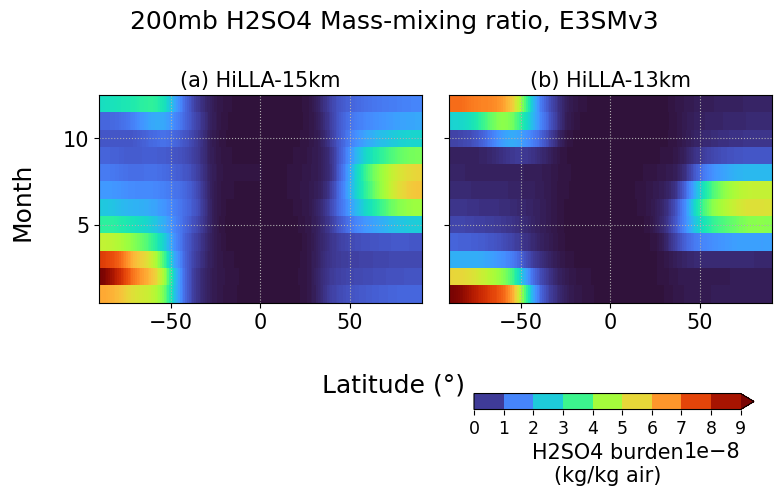

In [31]:
## also plot the E3SM mass mixing rations

fig, axs = plt.subplots(1, 2, figsize=(8, 4),
                        sharex='col', sharey='all')

ds_s = [ds_HiLLA_15_E3_200, ds_HiLLA_13_E3_200]
titles = ['(a) HiLLA-15km', '(b) HiLLA-13km']

i=0

for ds in ds_s:
    ax = axs[i]
    
    #cs=ax.contourf(ds.latitude, ds.month,
    #               ds.Mass_so4_200, cmap='turbo',
    #               levels = np.arange(0, 1E-7, 1E-8), 
    #               extend='max')

    pc = ax.pcolormesh(ds.latitude, ds.month,
                       ds.Mass_so4_200, cmap='turbo')
                       #levels = np.arange(0, 1E-7, 1E-8), 
                       #extend='max')


    ax.grid(ls='dotted')
    ax.set_title(titles[i], fontsize='medium')
    ax.set_ylim(0.5, 12.5)
    i=i+1
    
fig.supxlabel('Latitude (°)')
fig.supylabel('Month')

plt.tight_layout()


cbar_ax1 = fig.add_axes([0.6, -0.02, 0.35, 0.04])
cbar1 = fig.colorbar(cs, cax=cbar_ax1, orientation='horizontal', label='H2SO4 burden\n(kg/kg air)')
cbar1.ax.tick_params(labelsize='small')
plt.suptitle('200mb H2SO4 Mass-mixing ratio, E3SMv3')
plt.tight_layout()
#plt.savefig('Figures/', dpi=450, bbox_inches='tight')

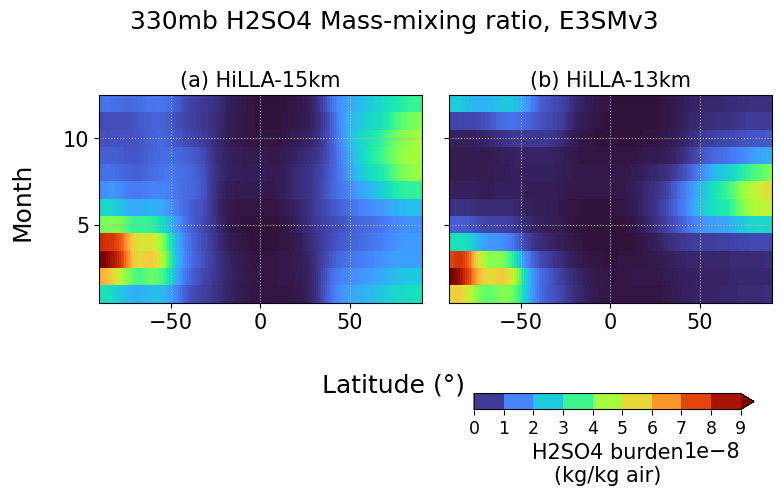

In [33]:
## also plot the E3SM mass mixing rations

fig, axs = plt.subplots(1, 2, figsize=(8, 4),
                        sharex='col', sharey='all')

ds_s = [ds_HiLLA_15_E3_330, ds_HiLLA_13_E3_330]
titles = ['(a) HiLLA-15km', '(b) HiLLA-13km']

i=0

for ds in ds_s:
    ax = axs[i]
    
    #cs=ax.contourf(ds.latitude, ds.month,
    #               ds.Mass_so4_200, cmap='turbo',
    #               levels = np.arange(0, 1E-7, 1E-8), 
    #               extend='max')

    pc = ax.pcolormesh(ds.latitude, ds.month,
                       ds.Mass_so4_330, cmap='turbo')
                       #levels = np.arange(0, 1E-7, 1E-8), 
                       #extend='max')


    ax.grid(ls='dotted')
    ax.set_title(titles[i], fontsize='medium')
    ax.set_ylim(0.5, 12.5)
    i=i+1
    
fig.supxlabel('Latitude (°)')
fig.supylabel('Month')

plt.tight_layout()


cbar_ax1 = fig.add_axes([0.6, -0.02, 0.35, 0.04])
cbar1 = fig.colorbar(cs, cax=cbar_ax1, orientation='horizontal', label='H2SO4 burden\n(kg/kg air)')
cbar1.ax.tick_params(labelsize='small')
plt.suptitle('330mb H2SO4 Mass-mixing ratio, E3SMv3')
plt.tight_layout()
#plt.savefig('Figures/', dpi=450, bbox_inches='tight')